In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda")

# dataset

In [2]:
DATA_PATH = "../../data/kaggle_data/"

In [3]:
def data_extract(df_dict, df, name, cols):
       for col in cols:
              df_dict[f"{name}_{col}"] = df.loc[df[col] != 0, col]
       return df_dict

train_data_list = []
val_data_list = []

pmj_df = pd.read_csv(DATA_PATH + "pjm_elec_daily.csv")
pmj_cols = ['AEP', 'COMED', 'DAYTON', 'DEOK', 'DOM', 'DUQ', 'FE', 'NI', 'PJME', 'PJMW'] # 'PJM_Load', 'EKPC'

df_dict = {}
df_dict = data_extract(df_dict, pmj_df, 'PMJ', pmj_cols)

train_data_dict, val_data_dict = {}, {}
train_rate = 0.8
for k in df_dict:
    
    train_len = int(train_rate * len(df_dict[k]))
    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(np.array(df_dict[k][:train_len]).reshape(-1, 1))
    val_data = scaler.transform(np.array(df_dict[k][train_len:]).reshape(-1, 1))

    train_data_dict[k] = (train_data, scaler)
    val_data_dict[k] = (val_data, scaler)
    break

In [4]:
from torch.utils.data import DataLoader, Dataset
class windowDataset(Dataset):
    def __init__(self, y, input_window=120, output_window=60, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x].squeeze()

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y].squeeze()

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [5]:
iw = 120
ow = 60
batch_size = 32

train_loader_dict, val_loader_dict = {}, {}

for k in train_data_dict:
    train_data, scaler = train_data_dict[k]
    train_dataset = windowDataset(train_data, input_window=iw, output_window=ow, stride=1)
    train_loader_dict[k] = (DataLoader(train_dataset, batch_size=batch_size), scaler)

# model

In [6]:
class TFModel(nn.Module):
    def __init__(self,iw, ow, d_model, nhead, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers) 
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        self.encoder = nn.Sequential(
            nn.Linear(1, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, d_model)
        )
        
        self.linear =  nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, 1)
        )

        self.linear2 = nn.Sequential(
            nn.Linear(iw, (iw+ow)//2),
            nn.ReLU(),
            nn.Linear((iw+ow)//2, ow)
        )
        # self.init_weights()

    # def init_weights(self):
    #     initrange = 0.1    
    #     self.encoder.bias.data.zero_()
    #     self.encoder.weight.data.uniform_(-initrange, initrange)

    #     self.linear.bias.data.zero_()
    #     self.linear.weight.data.uniform_(-initrange, initrange)

    #     self.linear2.bias.data.zero_()
    #     self.linear2.weight.data.uniform_(-initrange, initrange)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, srcmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src.transpose(0,1), srcmask).transpose(0,1)
        output = self.linear(output)[:,:,0]
        output = self.linear2(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

# training

In [7]:
def evaluate(model, train_data):
    input = torch.tensor(train_data[:120]).reshape(1,-1,1).to(device).float().to(device)
    model.eval()
    
    src_mask = model.generate_square_subsequent_mask(input.shape[1]).to(device)
    predictions = model(input, src_mask)
    return predictions.detach().cpu().numpy()

c:\Users\qja19\AppData\Local\anaconda3\envs\lstm\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


  0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\qja19\AppData\Local\anaconda3\envs\lstm\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


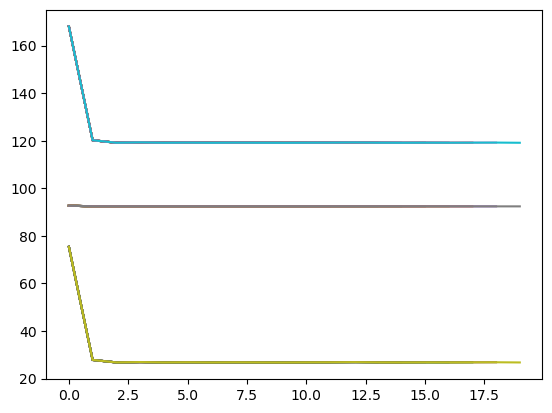

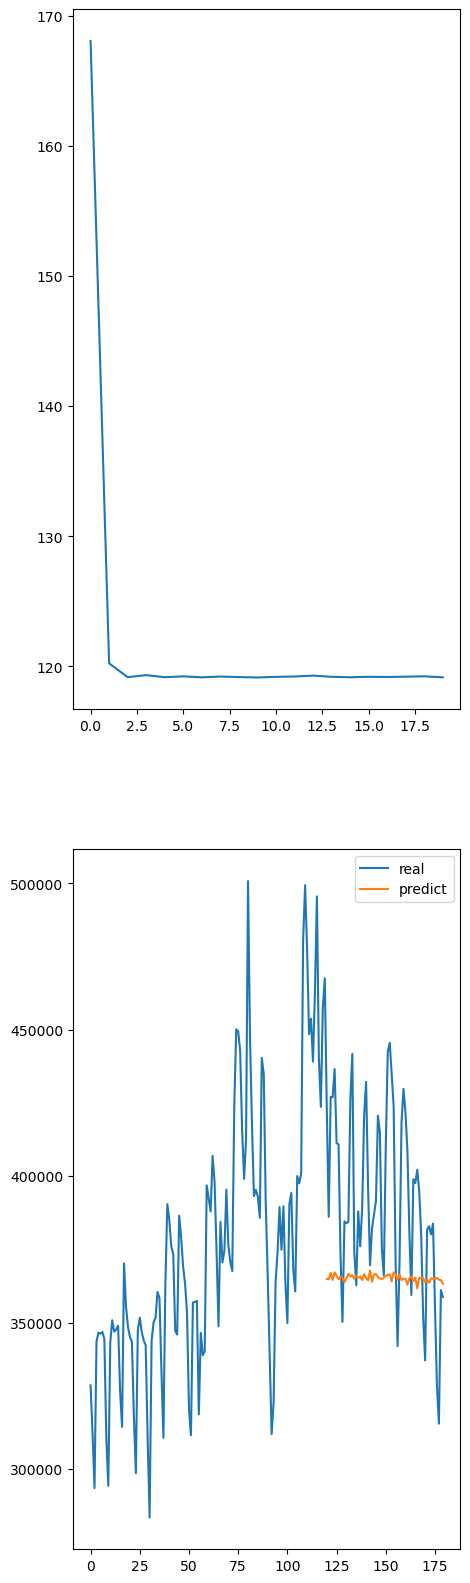

In [8]:
from torch.nn import MSELoss, L1Loss, CrossEntropyLoss, NLLLoss, PoissonNLLLoss, GaussianNLLLoss, KLDivLoss, SmoothL1Loss

# criterion_dict = {
#     # 'MSELoss' : MSELoss(),
#     # 'L1Loss' : L1Loss(),
#     # 'CrossEntropyLoss' : CrossEntropyLoss(),
#     # 'NLLLoss' : NLLLoss(),
#     # 'PoissonNLLLoss' : PoissonNLLLoss(),
#     # 'GaussianNLLLoss' : GaussianNLLLoss(),
#     # 'KLDivLoss' : KLDivLoss(),
#     # 'SmoothL1Loss' : SmoothL1Loss()
# }

lr = 1e-4
epoch = 20
early_stop_steps = None

model = TFModel(120, 60, 128, 8, 4, 0.1).to(device)
ce = CrossEntropyLoss()
mse = MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


model.train()
progress = tqdm(range(epoch))
loss_list = []
ce_list = []
mse_list = []
for i in progress:
    batchloss = 0.0
    batch_ce = .0
    batch_mse = .0
    for k in train_loader_dict:
        train_loader, scaler = train_loader_dict[k]
        for (inputs, outputs) in train_loader:
            optimizer.zero_grad()
            src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
            result = model(inputs.float().to(device), src_mask)
            ce_loss, mse_loss = ce(result, outputs[:,:,0].float().to(device)), mse(result, outputs[:,:,0].float().to(device))
            loss = ce_loss + 900 * mse_loss
            loss.backward()
            optimizer.step()

            batch_ce += ce_loss
            batch_mse += mse_loss
            batchloss += loss

    batch_ce = batch_ce.cpu().item() / len(train_loader)
    batch_mse = batch_mse.cpu().item() / len(train_loader)
    batchloss = batchloss.cpu().item() / len(train_loader)
    
    ce_list.append(batch_ce)
    mse_list.append(batch_mse * 900)
    loss_list.append(batchloss)
    
    progress.set_description("loss: {:0.6f}".format(batchloss))

    plt.plot(ce_list, label='CrossEntropyLoss')
    plt.plot(mse_list, label='MSELoss')
    plt.plot(loss_list, label='Loss')
    # plt.legend()
    plt.savefig(f"loss.png")

    if early_stop_steps and min(loss_list[-early_stop_steps:]) < batchloss:
        break

plt.figure(figsize=(5,20))
plt.subplot(211)
plt.plot(loss_list, label='loss')

for k in df_dict:
    train_data, scaler = train_data_dict[k]
    rawdata = df_dict[k]
    result = evaluate(model, train_data)
    result = scaler.inverse_transform(result)[0]
    real = rawdata.to_numpy()
    # real = scaler.inverse_transform(real.reshape(-1,1))[:,0]

    plt.subplot(212)
    plt.plot(range(0,180),real[:180], label="real")
    plt.plot(range(120,180),result, label="predict")
    plt.legend()
    plt.savefig(f"loss_pred.png")
    break
# plt.show()

In [9]:
ce_list, mse_list

([92.70363345816116,
  92.41720202737604,
  92.40583032024793,
  92.40583032024793,
  92.4059029571281,
  92.40587874483471,
  92.40595138171487,
  92.40591909865702,
  92.40578189566116,
  92.40583032024793,
  92.40586260330579,
  92.40586260330579,
  92.4059029571281,
  92.40573347107438,
  92.4058383910124,
  92.4057496126033,
  92.4057738248967,
  92.40566083419421,
  92.40566083419421,
  92.40569311725207],
 [75.37001302419615,
  27.810178709424232,
  26.76563873763912,
  26.91903094614833,
  26.76037008112127,
  26.82611745251112,
  26.751104268160734,
  26.81029197598292,
  26.768947829884933,
  26.740393165714487,
  26.785949044976352,
  26.813785497807274,
  26.882517436319144,
  26.790836428807786,
  26.755851556446927,
  26.79129218267015,
  26.77481056244905,
  26.8032659183849,
  26.82806814997649,
  26.750997866480805])

# evaluation

In [10]:
def evaluate(train_data):
    input = torch.tensor(train_data[:120]).reshape(1,-1,1).to(device).float().to(device)
    model.eval()
    
    src_mask = model.generate_square_subsequent_mask(input.shape[1]).to(device)
    predictions = model(input, src_mask)
    return predictions.detach().cpu().numpy()

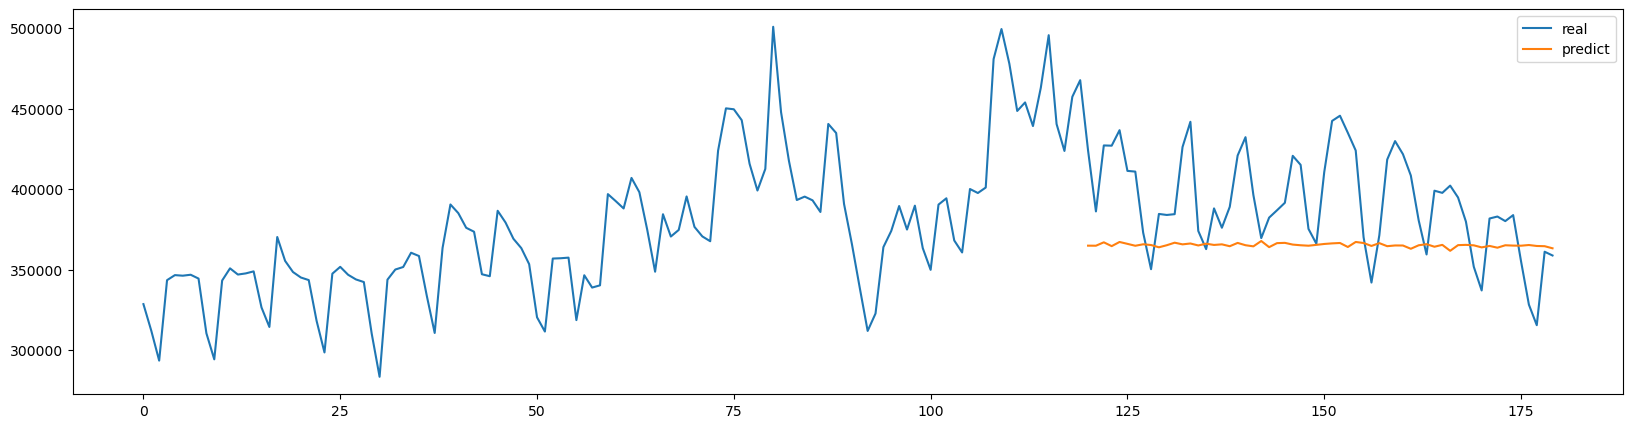

In [11]:

for k in df_dict:
    train_data, scaler = train_data_dict[k]
    rawdata = df_dict[k]
    result = evaluate(train_data)
    result = scaler.inverse_transform(result)[0]
    real = rawdata.to_numpy()
    # real = scaler.inverse_transform(real.reshape(-1,1))[:,0]


    plt.figure(figsize=(20,5))
    plt.plot(range(0,180),real[:180], label="real")
    plt.plot(range(120,180),result, label="predict")
    break
plt.legend()
plt.show()

In [12]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPEval(result, real[-24*7:])

ValueError: operands could not be broadcast together with shapes (168,) (60,) 